# Create a Siamese Network with Triplet Loss in Keras

### Task 1: Make the necessary imports

In [36]:
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


### Task 2: Importing the Data

In [8]:
def load_dataset():
    data = pd.read_csv('./training_dataset.csv')
    return data


data = load_dataset()

In [13]:
data.head(10)

,table name,column name,predicted labels by rule engine,accepted labels,discarded labels
0,Employee,Address,Address,Address,NaN
1,Employee,Age,"Age, Height, Weight",Age,"Weight, Height"
2,Employee,Address2,Address,Address,NaN
3,Customer,City,City,City,NaN
4,Customer,City2,City,City,NaN
5,Employee,Firstname,"Firstname, Lastname",Firstname,Lastname
6,Employee,Lastname,"Firstname, Lastname",Lastname,Firstname
7,Customer,Addr,Address,Address,NaN
8,Customer,C_T,"Telephone, Fax",Telephone,Fax
9,Customer,C_F,"Telephone, Fax",Fax,Telephone


### Task 3: Preprocessing the Training Dataset
Includes removal of punctuation marks, stop words, making text lowercase and concatenating the table and column name

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def strip_extension(table_name):
    return table_name.split('.')[0]

def preprocess_input():
    processed_samples = []
    for i, col_name in enumerate(data['column name']):
        
        # convert everything to lowercase
        table_name = data['table name'][i]
        
        # strip the extension from table name
        table_name = strip_extension(table_name)
        filtered_words = []
        
        # split the words on underscore
        filtered_words.extend(table_name.split('_'))
        filtered_words.extend(col_name.split('_'))
        
        # remove the stop words
        filtered_sentence = [w for w in filtered_words if not w.lower() in stop_words]
        content = ' '.join(filtered_sentence)
        
        # remove the punctuation marks
        content = re.sub(r'[^\w\s]', '', content)
        processed_samples.append(content.lower())
    return processed_samples

data['accepted labels'] = data['accepted labels'].replace(np.nan, 'NA', regex=True)
data['discarded labels'] = data['discarded labels'].replace(np.nan, 'NA', regex=True)

curated_data = pd.DataFrame()
curated_data['input'] = preprocess_input()
curated_data['accepted'] = [item.lower().split(',') for item in data['accepted labels']]
curated_data['discarded'] = [item.lower().split(',') for item in data['discarded labels']]

### View the Preprocessed Data

In [16]:
curated_data.head(10)

,input,accepted,discarded
0,employee address,[address],[na]
1,employee age,[age],"[weight, height]"
2,employee address2,[address],[na]
3,customer city,[city],[na]
4,customer city2,[city],[na]
5,employee firstname,[firstname],[lastname]
6,employee lastname,[lastname],[firstname]
7,customer addr,[address],[na]
8,customer c,[telephone],[fax]
9,customer c f,[fax],[telephone]


### Task 4: Import the universal sentence encoder

In [20]:
import tensorflow_hub as hub
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'

# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

2021-07-25 12:41:38.139639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Task 5: Building the Embedding Model

In [23]:
import keras
import keras.backend as K
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from keras.models import Sequential
from keras.layers.core import Lambda, Flatten, Dense

input_text = Input(shape=(512,))
x = BatchNormalization()(input_text)
x = Dense(256, activation='relu')(input_text)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

model=Model(inputs=[input_text], outputs=norm_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               1651

### Visual of Training data Embeddings before training

2021-07-25 12:47:33.870587: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


(36, 2)


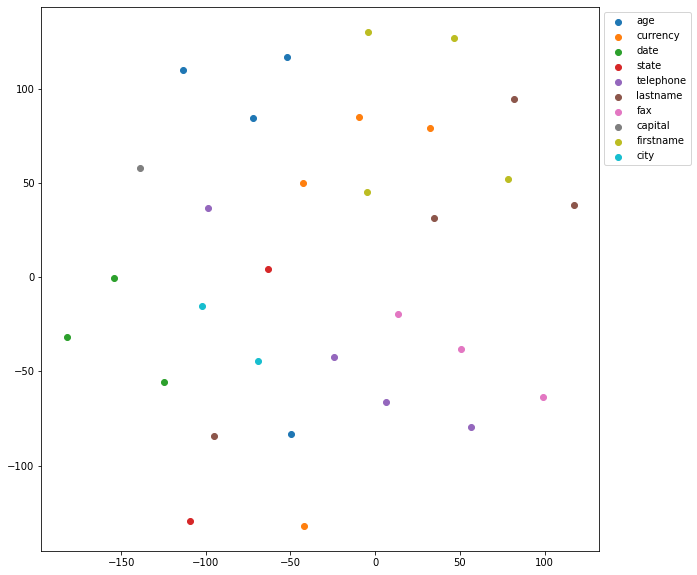

In [25]:
from sklearn.manifold import TSNE

unique_label_set = {label for ac_list in curated_data['accepted'] for label in ac_list}
labels_train = curated_data['accepted']
map_train_labels = {label: np.flatnonzero([label in item for item in labels_train]) for label in unique_label_set}

X_train = model.predict(np.array(embed(np.array(curated_data['input'].values.tolist()))['outputs']))
# print(X_train)
train_labels = np.asarray(curated_data['accepted'].values.tolist())
X_embedded = TSNE(n_components=2).fit_transform(X_train)
print(X_embedded.shape)
plt.figure(figsize=(10,10))
class_count = 0
for t in unique_label_set:
    class_count+=1
    if class_count > 10:
        break
    idx = map_train_labels[t]
    # print(idx)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));

### Generate Similarity Scores before training the model

In [27]:
from scipy import spatial

input_embeds = model.predict(np.array(embed(np.array(curated_data['input'].values.tolist()))['outputs']))
accepted_labels_embeds_list = [model.predict(np.array(embed(np.array(labels_list))['outputs'])) for labels_list in curated_data['accepted']]
rejected_labels_embeds_list = [model.predict(np.array(embed(np.array(labels_list))['outputs'])) for labels_list in curated_data['discarded']]

def get_cosine_similarity(embed1, embed2):
    return 1 - spatial.distance.cosine(embed1, embed2)

def get_distance(embed1, embed2):
    return spatial.distance.euclidean(embed1, embed2)
        
accepted_l_scores = []
for i, input_emb, accepted_label_embds in zip(range(len(input_embeds)), input_embeds, accepted_labels_embeds_list):
    if len(curated_data['accepted'][i]) == 1 and 'na' in curated_data['accepted'][i]:
        scores = [np.nan]
    else:
        scores = [get_cosine_similarity(input_emb, l_emb) for l_emb in accepted_label_embds]
    accepted_l_scores.append(scores)

rejected_l_scores = []
for i, input_emb, rejected_label_embds in zip(range(len(input_embeds)), input_embeds, rejected_labels_embeds_list):
    if len(curated_data['discarded'][i]) == 1 and 'na' in curated_data['discarded'][i]:
        scores = [np.nan]
    else:
        scores = [get_cosine_similarity(input_emb, l_emb) for l_emb in rejected_label_embds]
    rejected_l_scores.append(scores)
    
df_scores = pd.DataFrame()
df_scores['input'] = curated_data['input']
df_scores['accepted_scores'] = accepted_l_scores
df_scores['rejected_scores'] = rejected_l_scores

In [29]:
df_scores.tail(10)

,input,accepted_scores,rejected_scores
26,emp p age,[0.5739918351173401],"[0.4493856728076935, 0.3739703893661499]"
27,cust adr,[0.588754415512085],[nan]
28,cust cty,[0.4080255627632141],[0.519597589969635]
29,cust mlsg,[0.5343209505081177],"[0.5478670597076416, 0.4158746898174286]"
30,cust name fn,[0.5822041630744934],[0.5709499716758728]
31,cust name ln,[0.6597970128059387],[0.7087974548339844]
32,emp address1,[0.4185974597930908],[nan]
33,emp mob,[0.736223578453064],[nan]
34,emp fax,[0.8112805485725403],[0.6664381623268127]
35,emp f,[0.6377300024032593],[0.5714078545570374]


### Task 6: Creating a Siamese Network

In [30]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'alpha': self.alpha,
        })
        return config
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.6, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
net = Model([in_a, in_p, in_n], triplet_loss_layer)

In [31]:
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          181760      input_3[0][0]                    
                                                                 input_4[0][0]              

### Task 7: Data Generator

In [32]:
import random
# create a set of unique labels
unique_label_set = {label for ac_list in curated_data['accepted'] for label in ac_list}
# create a dict of unique labels
unique_label_dict = {label: i for i, label in enumerate(unique_label_set)}
labels_train = curated_data['accepted']

map_train_labels = {label: np.flatnonzero([label in item for item in labels_train]) for label in unique_label_set}

def get_triplets(unique_label_set, map_train_labels):
    while True:
        anchor, candidate_negative = np.random.choice(np.array(list(unique_label_set)), 2, replace=False)
        if anchor != 'na' and candidate_negative != 'na':
            break
    # print('anchor: {}, candidate_negative: {}'.format(anchor, candidate_negative))
    # get the positive 
    positive_idx = np.random.choice(map_train_labels[anchor], 1, replace=False)
    positive = random.choice(curated_data['input'][positive_idx].values.tolist())
    # print('positive: {}'.format(positive))
    negs = curated_data['discarded'][positive_idx].values.tolist()[0]
    if len(negs) > 1:
        negative = random.choice(negs)
    elif negs[0] == 'na':
        negative = candidate_negative
    else:
        negative = negs[0]
    return anchor, positive, negative


def get_triplets_batch(k, unique_label_set, map_train_labels, embed):
    while True:
        anchors, positives, negatives = [], [], []
        for _ in range(k):
            a, p, n = get_triplets(unique_label_set, map_train_labels)
            anchors.append(a)
            positives.append(p)
            negatives.append(n)
            
        a = embed(anchors)
        p = embed(positives)
        n = embed(negatives)
        yield [a,p,n], []

### Task 8: Training the Network

In [35]:
net.compile(loss=None, optimizer='adam')
net.fit(get_triplets_batch(64, 
                     unique_label_set,
                     map_train_labels,
                     embed), 
                     epochs=50,
                     steps_per_epoch=10)

Epoch 1/50
10/10 [==============================] - 12s 275ms/step - loss: 24.5853
Epoch 2/50
10/10 [==============================] - 2s 244ms/step - loss: 4.0076
Epoch 3/50
10/10 [==============================] - 2s 246ms/step - loss: 0.9431
Epoch 4/50
10/10 [==============================] - 3s 264ms/step - loss: 0.9293
Epoch 5/50
10/10 [==============================] - 3s 266ms/step - loss: 0.3893
Epoch 6/50
10/10 [==============================] - 3s 268ms/step - loss: 0.7093
Epoch 7/50
10/10 [==============================] - 2s 249ms/step - loss: 0.3816
Epoch 8/50
10/10 [==============================] - 3s 259ms/step - loss: 0.2372
Epoch 9/50
10/10 [==============================] - 3s 259ms/step - loss: 0.2275
Epoch 10/50
10/10 [==============================] - 3s 256ms/step - loss: 0.2127
Epoch 11/50
10/10 [==============================] - 3s 256ms/step - loss: 0.2023
Epoch 12/50
10/10 [==============================] - 3s 284ms/step - loss: 0.2878
Epoch 13/50
10/10 [====

### Visualization of Training Embeddings after the training

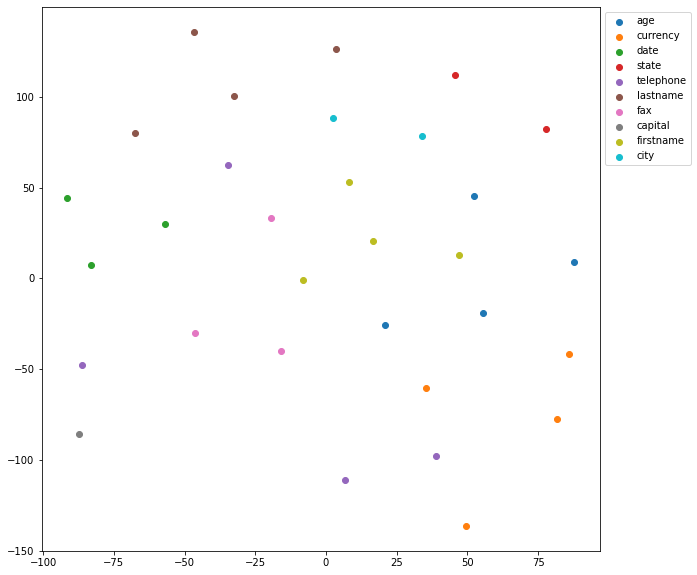

In [39]:
from sklearn.manifold import TSNE

X_train = model.predict(np.array(embed(np.array(curated_data['input'].values.tolist()))['outputs']))
# print(X_train)
train_labels = np.asarray(curated_data['accepted'].values.tolist())
X_embedded = TSNE(n_components=2).fit_transform(X_train)
# print(X_embedded.shape)
plt.figure(figsize=(10,10))
class_count = 0
for t in unique_label_set:
    class_count+=1
    if class_count > 10:
        break
    idx = map_train_labels[t]
    # print(idx)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)
plt.legend(bbox_to_anchor=(1, 1));

### Task 9: Inference

In [41]:
input_embeds = model.predict(np.array(embed(np.array(curated_data['input'].values.tolist()))['outputs']))
accepted_dd_embeds_list = [model.predict(np.array(embed(np.array(dd_list))['outputs'])) for dd_list in curated_data['accepted']]
rejected_dd_embeds_list = [model.predict(np.array(embed(np.array(dd_list))['outputs'])) for dd_list in curated_data['discarded']]

### Generate Similarity Scores after training the model

In [43]:
from scipy import spatial

input_embeds = model.predict(np.array(embed(np.array(curated_data['input'].values.tolist()))['outputs']))
accepted_labels_embeds_list = [model.predict(np.array(embed(np.array(labels_list))['outputs'])) for labels_list in curated_data['accepted']]
rejected_labels_embeds_list = [model.predict(np.array(embed(np.array(labels_list))['outputs'])) for labels_list in curated_data['discarded']]

def get_cosine_similarity(embed1, embed2):
    return 1 - spatial.distance.cosine(embed1, embed2)

def get_distance(embed1, embed2):
    return spatial.distance.euclidean(embed1, embed2)
        
accepted_l_scores = []
for i, input_emb, accepted_label_embds in zip(range(len(input_embeds)), input_embeds, accepted_labels_embeds_list):
    if len(curated_data['accepted'][i]) == 1 and 'na' in curated_data['accepted'][i]:
        scores = [np.nan]
    else:
        scores = [get_cosine_similarity(input_emb, l_emb) for l_emb in accepted_label_embds]
    accepted_l_scores.append(scores)

rejected_l_scores = []
for i, input_emb, rejected_label_embds in zip(range(len(input_embeds)), input_embeds, rejected_labels_embeds_list):
    if len(curated_data['discarded'][i]) == 1 and 'na' in curated_data['discarded'][i]:
        scores = [np.nan]
    else:
        scores = [get_cosine_similarity(input_emb, l_emb) for l_emb in rejected_label_embds]
    rejected_l_scores.append(scores)
    
df_scores = pd.DataFrame()
df_scores['input'] = curated_data['input']
df_scores['accepted_scores'] = accepted_l_scores
df_scores['rejected_scores'] = rejected_l_scores

In [44]:
df_scores.tail(10)

,input,accepted_scores,rejected_scores
26,emp p age,[0.9151754379272461],"[-0.6607479453086853, -0.6818423867225647]"
27,cust adr,[0.9076786041259766],[nan]
28,cust cty,[0.5837949514389038],[-0.13901273906230927]
29,cust mlsg,[0.4479970932006836],"[-0.19428063929080963, -0.16767339408397675]"
30,cust name fn,[0.7259544134140015],[-0.43481603264808655]
31,cust name ln,[0.5043555498123169],[-0.18636652827262878]
32,emp address1,[0.9249179363250732],[nan]
33,emp mob,[0.9223858118057251],[nan]
34,emp fax,[0.8819968104362488],[-0.641097366809845]
35,emp f,[0.6794732213020325],[-0.5522856712341309]
